In [8]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report

ImportError: cannot import name 'clip_to_image_size' from 'keras.src.layers.preprocessing.image_preprocessing.bounding_boxes.converters' (C:\Users\wimmu\anaconda3\envs\Neuroverkot\Lib\site-packages\keras\src\layers\preprocessing\image_preprocessing\bounding_boxes\converters.py)

Kuvat haetaan kansiorakenteesta, jossa on erilliset kansiot koulutukselle, validoinnille ja testaukselle.

Data-augmentaatiota käytetään koulutusdatassa ylikapasitoinnin estämiseksi. Tämä on erityisen tärkeää, kun käytössä on pieni datasetti, sillä se auttaa mallia yleistämään paremmin muuttuvissa olosuhteissa.

In [131]:
new_base_dir = "kuvat"

train_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "train"),
    image_size=(224, 224),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "validation"),
    image_size=(224, 224),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "test"),
    image_size=(224, 224),
    batch_size=32
)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

Found 126 files belonging to 3 classes.
Found 27 files belonging to 3 classes.
Found 27 files belonging to 3 classes.


Malli rakennetaan käyttäen Kerasin Sequential-rakennetta.
Tässä mallissä käytämme kolmea konvoluutiokerrosta, joiden jälkeen seuraa tiheä (dense) kerros ja lopuksi luokittelukerros.
Dropout-kerros auttaa ehkäisemään ylikapasitointia.
Malli on suunniteltu luokittelemaan kuvat kolmeen eri luokkaan.

model.summary()-komennolla tulostetaan mallin rakenne ja kunkin kerroksen parametrit.

In [132]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Malli käännetään (compile) käyttäen Adam-optimointialgoritmia, joka on tehokas ja yleisesti käytetty valinta syväoppimisessa.

Häviöfunktioksi valitaan sparse_categorical_crossentropy, koska luokkia on useita ja opetusdata käyttää kokonaislukuja (ei one-hot-vektoreita) luokkien merkkaamiseen. Tämä toimii hyvin myös pienemmillä dataseteillä.

Suorituskykymittarina käytetään accuracy-metriikkaa eli tarkkuutta, joka kertoo, kuinka usein malli luokittelee oikein.

Mallia opetetaan 30 epookin ajan (epochs=30) koulutusdatalla. Tavoitteena on, että malli oppii yleistämään datasta mahdollisimman hyvin ja saavuttaa korkean tarkkuuden myös validointidatalla.

Lopuksi mallin suoritus testidatalla arvioidaan evaluate()-komennolla. Tuloksena saadaan testihäviö ja testitarkkuus, joka kertoo kuinka hyvin malli toimii kokonaan uusilla, aiemmin näkemättömillä kuvilla

In [133]:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30
)

training_time = time.time() - start_time

test_loss, test_acc = model.evaluate(test_dataset)

# Save results
np.savez("CNN_kuvantunnistus_results.npz",
         test_acc=test_acc,
         test_loss=test_loss,
         training_time=training_time,
         history=history.history)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.3552 - loss: 692.6652 - val_accuracy: 0.3333 - val_loss: 52.8586
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.2988 - loss: 51.6971 - val_accuracy: 0.3333 - val_loss: 48.4069
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - accuracy: 0.3562 - loss: 31.9654 - val_accuracy: 0.3333 - val_loss: 6.7116
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.3647 - loss: 5.7997 - val_accuracy: 0.3333 - val_loss: 2.2632
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.3501 - loss: 1.8731 - val_accuracy: 0.3333 - val_loss: 1.3714
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.4222 - loss: 1.2417 - val_accuracy: 0.2963 - val_loss: 1.1085
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.4235 - loss: 1.0675 - val_accuracy: 0.3704 - val_loss: 1.0568
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.3996 - loss: 1.0785 - val_accuracy: 0.3704 - val

In [134]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Testin tarkkuus: {test_acc:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5185 - loss: 0.9972
Testin tarkkuus: 0.519


Lopuksi malli arvioidaan testidatalla, jolla ei ole ollut vaikutusta koulutukseen tai validointiin. Tämä antaa rehellisen arvion mallin todellisesta yleistämiskyvystä.

Testin kokonaistarkkuus oli noin 52 %, mikä on vain hieman parempi kuin satunnaisvalinta (kolmessa luokassa satunnainen arvaus tuottaa keskimäärin 33 % tarkkuuden).

Luokitteluraportti paljastaa, että lusikka-luokka tunnistetaan parhaiten, kun taas haarukka ja veitsi menevät helposti sekaisin.

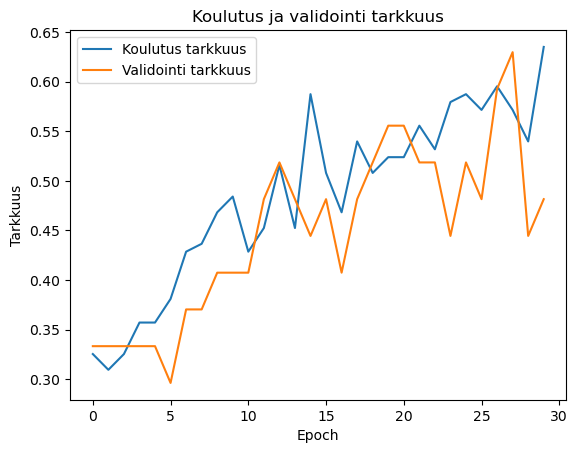

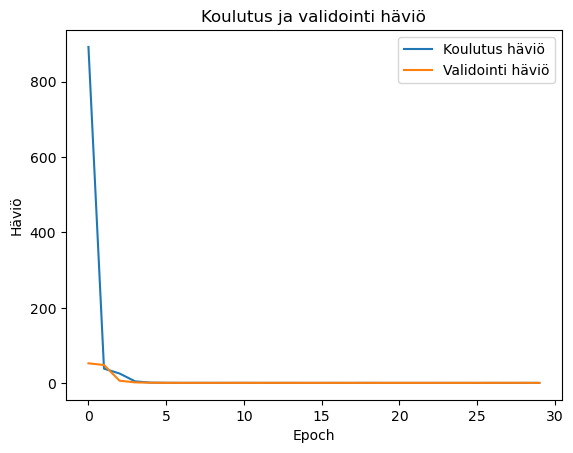

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
              precision    recall  f1-score   support

    haarukka       0.50      0.33      0.40         9
     lusikka       0.45      0.56      0.50         9
      veitsi       0.30      0.33      0.32         9

    accuracy                           0.41        27
   macro avg       0.42      0.41      0.41        27
weighted avg       0.42      0.41      0.41        27



In [135]:
plt.plot(history.history['accuracy'], label='Koulutus tarkkuus')
plt.plot(history.history['val_accuracy'], label='Validointi tarkkuus')
plt.title('Koulutus ja validointi tarkkuus')
plt.xlabel('Epoch')
plt.ylabel('Tarkkuus')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Koulutus häviö')
plt.plot(history.history['val_loss'], label='Validointi häviö')
plt.title('Koulutus ja validointi häviö')
plt.xlabel('Epoch')
plt.ylabel('Häviö')
plt.legend()
plt.show()

test_labels = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset.map(lambda x, y: x)), axis=1)

print(classification_report(test_labels, y_pred, target_names=['haarukka', 'lusikka', 'veitsi']))